In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, random_split
import copy
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageFilter
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"using:{torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("using CPU")

using:Tesla T4


In [3]:

class InitialTransforms:
    def __init__(self, size=(224, 224)):
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, img):
        return self.transform(img)

class Acuity:
    def __init__(self, age_months):
        self.age_months = age_months
        self.acuity_map = {
            (0, 1): 4.0,  # "20/600"
            (2, 3): 3.0,  # "20/489"
            (4, 6): 2.0,  # "20/373"
            (7, 9): 1.0,  # "20/221"
            (10, float('inf')): 0.0  # "20/20"
        }

    def __call__(self, image):
        if not isinstance(image, Image.Image):
            raise TypeError("Expected input type is PIL Image.")
        
        blur_radius = next(radius for (low, high), radius in self.acuity_map.items() 
                           if low <= self.age_months <= high)
        return image.filter(ImageFilter.GaussianBlur(radius=blur_radius))

class Contrast:
    def __init__(self, age_months):
        self.age_months = age_months
        self.sensitivity_map = {
            (0, 1): 2,
            (2, 4): 8,
            (5, 6): 20,
            (7, 8): 30,
            (9, 10): 45,
            (11, float('inf')): 50
        }

    def __call__(self, image):
        if not isinstance(image, Image.Image):
            raise TypeError("Expected input type is PIL Image.")
        
        peak_sensitivity = next(sens for (low, high), sens in self.sensitivity_map.items() 
                                if low <= self.age_months <= high)
        contrast_sensitivity = peak_sensitivity / 50

        image_array = np.array(image).astype(np.float32) / 255.0
        adjusted = np.clip(((image_array - 0.5) * contrast_sensitivity) + 0.5, 0, 1)
        return Image.fromarray((adjusted * 255).astype(np.uint8))


In [4]:

from torchvision.models import alexnet

def get_model(num_classes=10, fine_tune=True):
    model = alexnet(pretrained=False)
    # replace the last layer
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

model_v1 = get_model(num_classes=10)
print(model_v1)

trainable_params = sum(p.numel() for p in model_v1.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Data Loader part goes here...


100%|██████████| 170498071/170498071 [00:02<00:00, 57421120.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


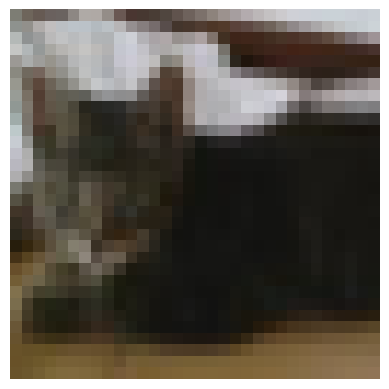

In [5]:
# load CIFAR-10 dataset
base_train_dataset = CIFAR10(root='./data', train=True, download=True)
# display the image
img = base_train_dataset[9][0]
plt.imshow(img)
plt.axis('off')
plt.show()


In [6]:

# define age groups and batch size
age_groups = [3, 6, 12]  # Developmental ages in months
batch_size = 32

# initialize DataLoader containers
train_loaders, val_loaders = [], []

# load the base dataset once
base_train_dataset = CIFAR10(root='./data', train=True, download=True)

for age_months in age_groups:
    print(f"Processing data for age group: {age_months} months")
    
    # defining transformations
    transform = transforms.Compose([
       
        Acuity(age_months=age_months),
        Contrast(age_months=age_months),
        transforms.ToTensor(),
        # transforms.Resize(256)
        
    ])
    
    # create a new dataset with the transformation
    transformed_dataset = CIFAR10(root='./data', train=True, download=False, transform=transform)
    
    # split train dataset into training and validation sets
    generator = torch.Generator().manual_seed(42)  # For reproducibility
    train_size = int(0.8 * len(transformed_dataset))
    val_size = len(transformed_dataset) - train_size
    train_data, val_data = random_split(transformed_dataset, [train_size, val_size], generator=generator)

    # create DataLoaders for the transformed data
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # append the loaders for each age group
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

print("Data loaders created for all age groups.")


Files already downloaded and verified
Processing data for age group: 3 months
Processing data for age group: 6 months
Processing data for age group: 12 months
Data loaders created for all age groups.


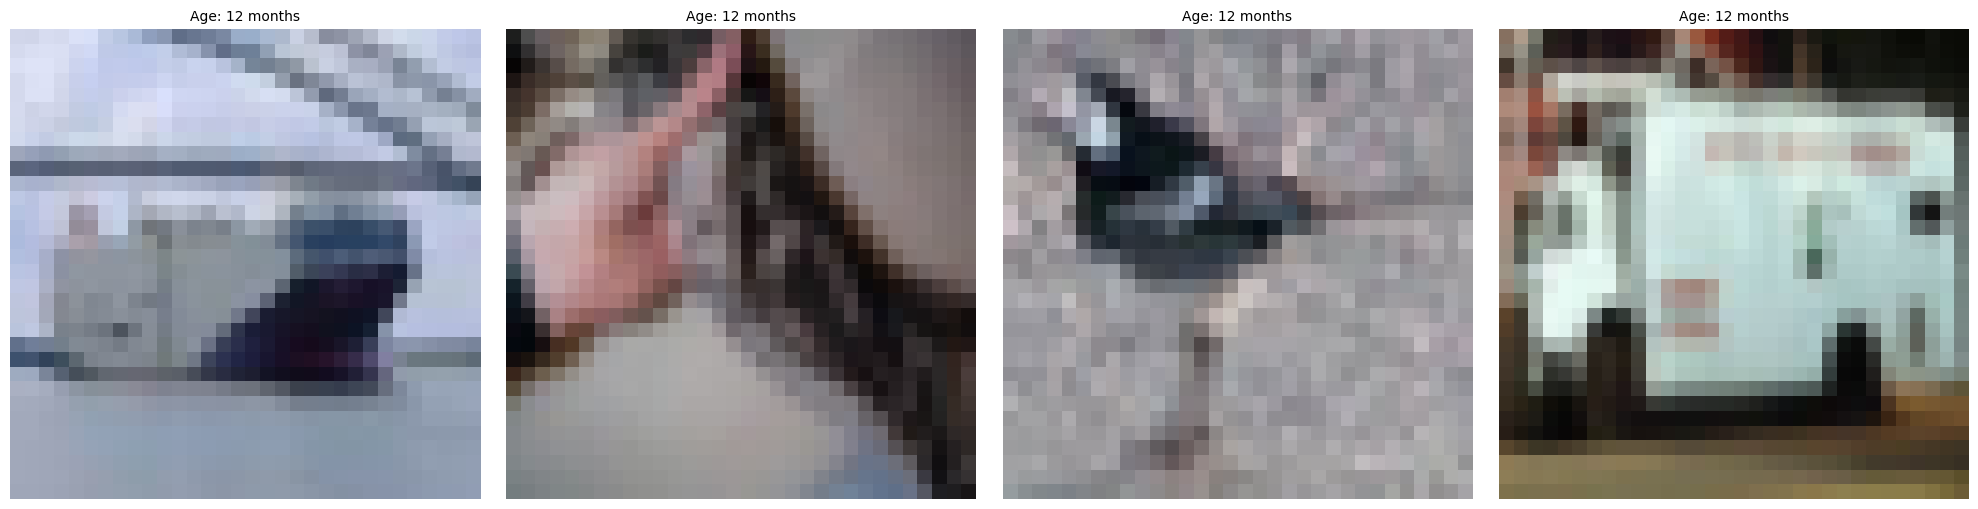

In [7]:

def visualize_transformed_loader(train_loader, age_groups, num_images=4):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    # determine the number of images we can display
    batch_size = images.shape[0]
    num_images = min(num_images, batch_size)

    # plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        
        if img.max() <= 1:
            img = (img * 255).astype('uint8')
        
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Age: {age_groups[-1]} months", fontsize=10)

    plt.tight_layout()
    plt.show()

# visualize the transformed images

visualize_transformed_loader(train_loaders[-1], age_groups)


In [8]:
print(f"Images in training dataset: {len(train_data)}")
print(f"Images in validation dataset: {len(val_data)}")

total_train_images = sum(len(loader.dataset) for loader in train_loaders)
total_val_images = sum(len(loader.dataset) for loader in val_loaders)

print(f"Total training images across all age groups: {total_train_images}")
print(f"Total validation images across all age groups: {total_val_images}")


Images in training dataset: 40000
Images in validation dataset: 10000
Total training images across all age groups: 120000
Total validation images across all age groups: 30000


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 32 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

num_epochs = 5
scaler = GradScaler()
best_val_loss = float('inf')

train_accuracies = []
val_accuracies = []

# loop over each age group
for age_group_index, age_group in enumerate(age_groups):
    print(f"Training for Age Group: {age_group} months")
    train_loader = train_loaders[age_group_index]  # get the corresponding train loader
    val_loader = val_loaders[age_group_index]      # get the corresponding validation loader
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Training (Age: {age_group} months)")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():  # mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'accuracy': 100. * correct / total})
        
        train_loss = running_loss / total
        train_acc = 100. * correct / total
        train_accuracies.append(train_acc)  # storing training accuracy
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Validation (Age: {age_group} months)")
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({'loss': loss.item(), 'accuracy': 100. * correct / total})
        
        val_loss /= total
        val_acc = 100. * correct / total
        val_accuracies.append(val_acc)  # storing validation accuracy
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)

print("Training completed.")

torch.save(model.state_dict(),"curriculum.pth")


<ipython-input-10-667fdaff784c>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # for mixed precision training


Training for Age Group: 3 months
Epoch 1/5


Training (Age: 3 months):   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-10-667fdaff784c>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
Training (Age: 3 months): 100%|██████████| 1250/1250 [00:11<00:00, 111.59it/s, loss=2.09, accuracy=18.7]


Train Loss: 0.0674, Train Acc: 18.72%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 143.17it/s, loss=1.94, accuracy=28.3]


Validation Loss: 0.0619, Validation Acc: 28.28%
Epoch 2/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:09<00:00, 129.33it/s, loss=1.92, accuracy=32.1]


Train Loss: 0.0587, Train Acc: 32.08%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 152.34it/s, loss=1.83, accuracy=33.7]


Validation Loss: 0.0573, Validation Acc: 33.69%
Epoch 3/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:10<00:00, 124.17it/s, loss=1.55, accuracy=37.4]


Train Loss: 0.0548, Train Acc: 37.37%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 152.32it/s, loss=1.79, accuracy=38.9]


Validation Loss: 0.0531, Validation Acc: 38.88%
Epoch 4/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:09<00:00, 129.86it/s, loss=1.35, accuracy=39.7]


Train Loss: 0.0527, Train Acc: 39.72%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 154.60it/s, loss=1.82, accuracy=40.9]


Validation Loss: 0.0523, Validation Acc: 40.90%
Epoch 5/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:09<00:00, 132.14it/s, loss=1.69, accuracy=41.2]


Train Loss: 0.0515, Train Acc: 41.21%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 118.28it/s, loss=1.6, accuracy=41.7]


Validation Loss: 0.0507, Validation Acc: 41.72%
Training for Age Group: 6 months
Epoch 1/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:09<00:00, 132.15it/s, loss=1.85, accuracy=43.6]


Train Loss: 0.0498, Train Acc: 43.59%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:02<00:00, 150.49it/s, loss=1.6, accuracy=44.3]


Validation Loss: 0.0489, Validation Acc: 44.32%
Epoch 2/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:09<00:00, 131.15it/s, loss=1.42, accuracy=45.4]


Train Loss: 0.0479, Train Acc: 45.41%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:02<00:00, 153.75it/s, loss=1.54, accuracy=45.5]


Validation Loss: 0.0475, Validation Acc: 45.53%
Epoch 3/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:10<00:00, 121.71it/s, loss=1.83, accuracy=46.8]


Train Loss: 0.0467, Train Acc: 46.81%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:02<00:00, 153.94it/s, loss=1.53, accuracy=46.2]


Validation Loss: 0.0461, Validation Acc: 46.24%
Epoch 4/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:09<00:00, 131.43it/s, loss=1.36, accuracy=48]


Train Loss: 0.0456, Train Acc: 47.96%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:02<00:00, 155.40it/s, loss=1.47, accuracy=46.7]


Validation Loss: 0.0460, Validation Acc: 46.71%
Epoch 5/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:09<00:00, 131.13it/s, loss=1.47, accuracy=49.1]


Train Loss: 0.0447, Train Acc: 49.10%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:02<00:00, 153.45it/s, loss=1.37, accuracy=47.7]


Validation Loss: 0.0458, Validation Acc: 47.68%
Training for Age Group: 12 months
Epoch 1/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:09<00:00, 129.68it/s, loss=1.39, accuracy=50.9]


Train Loss: 0.0431, Train Acc: 50.88%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 159.29it/s, loss=1.17, accuracy=52.7]


Validation Loss: 0.0410, Validation Acc: 52.67%
Epoch 2/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 140.10it/s, loss=1.44, accuracy=55]


Train Loss: 0.0390, Train Acc: 55.01%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:02<00:00, 155.84it/s, loss=1.17, accuracy=55.1]


Validation Loss: 0.0392, Validation Acc: 55.11%
Epoch 3/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:09<00:00, 137.99it/s, loss=0.771, accuracy=58.6]


Train Loss: 0.0361, Train Acc: 58.62%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 167.53it/s, loss=1.3, accuracy=59]


Validation Loss: 0.0360, Validation Acc: 59.00%
Epoch 4/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:09<00:00, 128.55it/s, loss=0.981, accuracy=61.4]


Train Loss: 0.0339, Train Acc: 61.37%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 167.01it/s, loss=1.24, accuracy=59.4]


Validation Loss: 0.0354, Validation Acc: 59.40%
Epoch 5/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:09<00:00, 138.50it/s, loss=0.957, accuracy=63.7]


Train Loss: 0.0319, Train Acc: 63.73%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 169.56it/s, loss=1.3, accuracy=61.6]


Validation Loss: 0.0341, Validation Acc: 61.59%
Training completed.


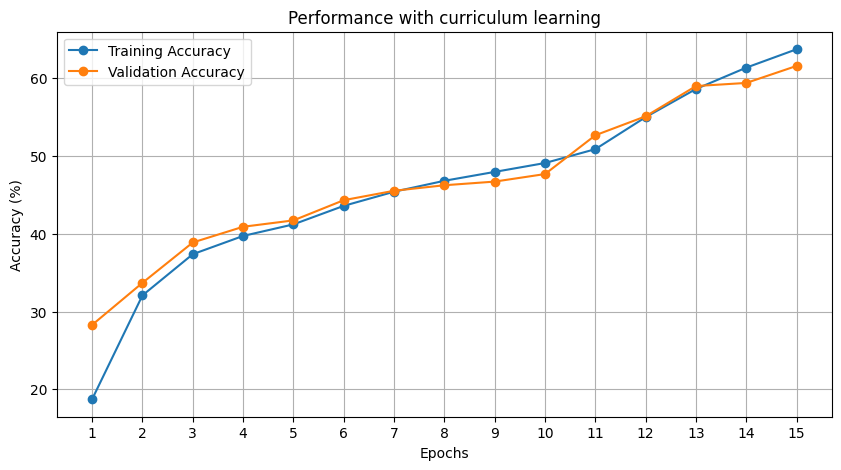

In [11]:
# Plotting the accuracies after training is done
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Performance with curriculum learning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(train_accuracies) + 1))  # Set x-ticks for each epoch
plt.legend()
plt.grid(True)
plt.savefig("with Curriculum")
plt.show()

In [12]:

# Define age groups and batch size
age_groups = [3, 6, 12]  # Developmental ages in months
batch_size = 32

# Initialize DataLoader containers
train_loaders, val_loaders = [], []

# Load the base dataset once
base_train_dataset = CIFAR10(root='./data', train=True, download=True)

for age_months in age_groups:
    print(f"Processing data for age group: {age_months} months")
    
    # Define transformations
    transform = transforms.Compose([
       
        Acuity(age_months=age_months),
        # Contrast(age_months=age_months),
        transforms.ToTensor(),
        # transforms.Resize(256)
        
    ])
    
    # Create a new dataset with the transformation
    transformed_dataset = CIFAR10(root='./data', train=True, download=False, transform=transform)
    
    # Split train dataset into training and validation sets
    generator = torch.Generator().manual_seed(42)  # For reproducibility
    train_size = int(0.8 * len(transformed_dataset))
    val_size = len(transformed_dataset) - train_size
    train_data, val_data = random_split(transformed_dataset, [train_size, val_size], generator=generator)

    # Create DataLoaders for the transformed data
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Append the loaders for each age group
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

print("Data loaders created for all age groups.")


Files already downloaded and verified
Processing data for age group: 3 months
Processing data for age group: 6 months
Processing data for age group: 12 months
Data loaders created for all age groups.


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

num_epochs = 5
scaler = GradScaler()  # for mixed precision training

best_val_loss = float('inf')

# lists to store accuracy values
train_accuracies = []
val_accuracies = []

# loop over each age group
for age_group_index, age_group in enumerate(age_groups):
    print(f"Training for Age Group: {age_group} months")
    train_loader = train_loaders[age_group_index]
    val_loader = val_loaders[age_group_index]
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Training (Age: {age_group} months)")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():  # mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'accuracy': 100. * correct / total})
        
        train_loss = running_loss / total
        train_acc = 100. * correct / total
        train_accuracies.append(train_acc)  # storing training accuracy
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Validation (Age: {age_group} months)")
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({'loss': loss.item(), 'accuracy': 100. * correct / total})
        
        val_loss /= total
        val_acc = 100. * correct / total
        val_accuracies.append(val_acc)  # storing validation accuracy
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)

print("Training completed.")
torch.save(model.state_dict(),"onlyAcuity.pth")


<ipython-input-13-76e087fabd74>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # for mixed precision training


Training for Age Group: 3 months
Epoch 1/5


Training (Age: 3 months):   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-13-76e087fabd74>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
Training (Age: 3 months): 100%|██████████| 1250/1250 [00:08<00:00, 142.11it/s, loss=1.86, accuracy=35.5]


Train Loss: 0.0559, Train Acc: 35.52%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:01<00:00, 167.08it/s, loss=1.47, accuracy=42.5]


Validation Loss: 0.0509, Validation Acc: 42.49%
Epoch 2/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:08<00:00, 139.15it/s, loss=1.35, accuracy=44.1]


Train Loss: 0.0488, Train Acc: 44.11%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 128.28it/s, loss=1.28, accuracy=45.5]


Validation Loss: 0.0476, Validation Acc: 45.53%
Epoch 3/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:09<00:00, 133.05it/s, loss=1.5, accuracy=48.2]


Train Loss: 0.0456, Train Acc: 48.19%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 108.52it/s, loss=1.51, accuracy=48.7]


Validation Loss: 0.0452, Validation Acc: 48.70%
Epoch 4/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:09<00:00, 135.97it/s, loss=1.36, accuracy=50.5]


Train Loss: 0.0435, Train Acc: 50.54%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 118.30it/s, loss=1.2, accuracy=50.6]


Validation Loss: 0.0435, Validation Acc: 50.64%
Epoch 5/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:08<00:00, 144.75it/s, loss=1.43, accuracy=52.2]


Train Loss: 0.0419, Train Acc: 52.24%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:01<00:00, 184.91it/s, loss=1.17, accuracy=52.5]


Validation Loss: 0.0417, Validation Acc: 52.50%
Training for Age Group: 6 months
Epoch 1/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:09<00:00, 136.72it/s, loss=1.1, accuracy=55.5]


Train Loss: 0.0390, Train Acc: 55.55%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:02<00:00, 155.55it/s, loss=1.1, accuracy=54]


Validation Loss: 0.0403, Validation Acc: 54.04%
Epoch 2/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:08<00:00, 145.01it/s, loss=1.21, accuracy=57.4]


Train Loss: 0.0373, Train Acc: 57.43%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:01<00:00, 187.27it/s, loss=1.14, accuracy=56.2]


Validation Loss: 0.0386, Validation Acc: 56.16%
Epoch 3/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:08<00:00, 144.76it/s, loss=0.842, accuracy=58.7]


Train Loss: 0.0361, Train Acc: 58.69%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:01<00:00, 185.48it/s, loss=1.22, accuracy=56.7]


Validation Loss: 0.0382, Validation Acc: 56.72%
Epoch 4/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:08<00:00, 142.32it/s, loss=1.25, accuracy=60.2]


Train Loss: 0.0350, Train Acc: 60.23%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:02<00:00, 136.79it/s, loss=1.12, accuracy=57.6]


Validation Loss: 0.0374, Validation Acc: 57.61%
Epoch 5/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:08<00:00, 144.13it/s, loss=1.17, accuracy=61.2]


Train Loss: 0.0340, Train Acc: 61.20%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:01<00:00, 186.80it/s, loss=1.26, accuracy=57.8]


Validation Loss: 0.0376, Validation Acc: 57.77%
Training for Age Group: 12 months
Epoch 1/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 149.52it/s, loss=0.953, accuracy=63.1]


Train Loss: 0.0326, Train Acc: 63.05%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 202.87it/s, loss=1.09, accuracy=60.4]


Validation Loss: 0.0355, Validation Acc: 60.42%
Epoch 2/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 148.67it/s, loss=0.849, accuracy=66.1]


Train Loss: 0.0299, Train Acc: 66.11%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 179.48it/s, loss=1.21, accuracy=61.9]


Validation Loss: 0.0343, Validation Acc: 61.85%
Epoch 3/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 139.66it/s, loss=1.05, accuracy=68.4]


Train Loss: 0.0279, Train Acc: 68.38%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 204.52it/s, loss=1.48, accuracy=62.6]


Validation Loss: 0.0340, Validation Acc: 62.58%
Epoch 4/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 148.12it/s, loss=0.647, accuracy=70.3]


Train Loss: 0.0262, Train Acc: 70.28%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 202.37it/s, loss=1.23, accuracy=62.3]


Validation Loss: 0.0340, Validation Acc: 62.32%
Epoch 5/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 149.34it/s, loss=0.646, accuracy=72]


Train Loss: 0.0247, Train Acc: 71.98%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 206.41it/s, loss=1.38, accuracy=63.5]


Validation Loss: 0.0337, Validation Acc: 63.46%
Training completed.


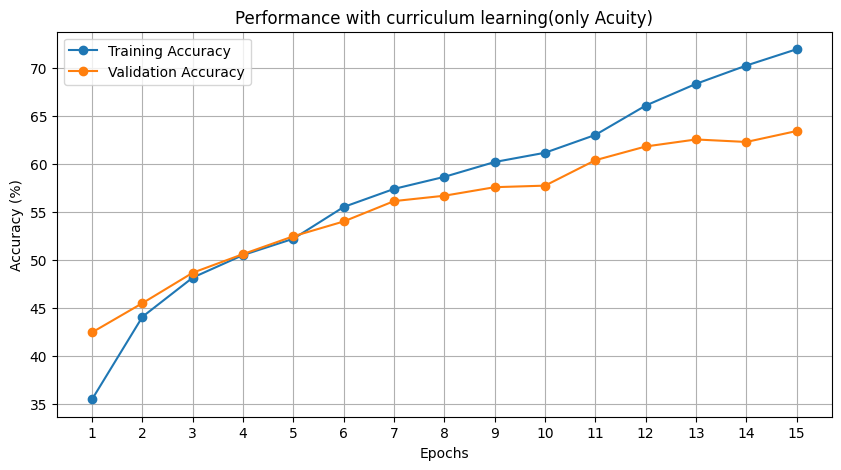

In [14]:
# plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Performance with curriculum learning(only Acuity)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(train_accuracies) + 1))
plt.legend()
plt.grid(True)
plt.savefig("only Acuity")

plt.show()

In [15]:

age_groups = [3, 6, 12]
batch_size = 32

train_loaders, val_loaders = [], []

base_train_dataset = CIFAR10(root='./data', train=True, download=True)

for age_months in age_groups:
    print(f"Processing data for age group: {age_months} months")
    
 
    transform = transforms.Compose([
       
        # Acuity(age_months=age_months),
        Contrast(age_months=age_months),
        transforms.ToTensor(),
        # transforms.Resize(256)
        
    ])
    
    # Create a new dataset with the transformation
    transformed_dataset = CIFAR10(root='./data', train=True, download=False, transform=transform)
    
    generator = torch.Generator().manual_seed(42)  
    train_size = int(0.8 * len(transformed_dataset))
    val_size = len(transformed_dataset) - train_size
    train_data, val_data = random_split(transformed_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

print("Data loaders created for all age groups.")


Files already downloaded and verified
Processing data for age group: 3 months
Processing data for age group: 6 months
Processing data for age group: 12 months
Data loaders created for all age groups.


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

num_epochs = 5
scaler = GradScaler()

best_val_loss = float('inf')

train_accuracies = []
val_accuracies = []

for age_group_index, age_group in enumerate(age_groups):
    print(f"Training for Age Group: {age_group} months")
    train_loader = train_loaders[age_group_index]
    val_loader = val_loaders[age_group_index]
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Training (Age: {age_group} months)")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'accuracy': 100. * correct / total})
        
        train_loss = running_loss / total
        train_acc = 100. * correct / total
        train_accuracies.append(train_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Validation (Age: {age_group} months)")
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({'loss': loss.item(), 'accuracy': 100. * correct / total})
        
        val_loss /= total
        val_acc = 100. * correct / total
        val_accuracies.append(val_acc) 
        
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)

print("Training completed.")
torch.save(model.state_dict(),"onlyContrast.pth")


<ipython-input-16-874169da2cfe>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # for mixed precision training


Training for Age Group: 3 months
Epoch 1/5


Training (Age: 3 months):   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-16-874169da2cfe>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
Training (Age: 3 months): 100%|██████████| 1250/1250 [00:08<00:00, 141.19it/s, loss=2.07, accuracy=20.1]


Train Loss: 0.0664, Train Acc: 20.12%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 146.99it/s, loss=1.75, accuracy=31.1]


Validation Loss: 0.0594, Validation Acc: 31.06%
Epoch 2/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:08<00:00, 140.87it/s, loss=1.68, accuracy=33.8]


Train Loss: 0.0570, Train Acc: 33.80%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:01<00:00, 172.41it/s, loss=1.57, accuracy=38.9]


Validation Loss: 0.0537, Validation Acc: 38.85%
Epoch 3/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:08<00:00, 141.95it/s, loss=1.23, accuracy=39.6]


Train Loss: 0.0523, Train Acc: 39.59%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 144.80it/s, loss=1.67, accuracy=42.1]


Validation Loss: 0.0500, Validation Acc: 42.14%
Epoch 4/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:09<00:00, 133.82it/s, loss=1.47, accuracy=42.3]


Train Loss: 0.0499, Train Acc: 42.34%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:02<00:00, 153.54it/s, loss=1.56, accuracy=44.9]


Validation Loss: 0.0479, Validation Acc: 44.89%
Epoch 5/5


Training (Age: 3 months): 100%|██████████| 1250/1250 [00:09<00:00, 137.56it/s, loss=1.68, accuracy=44.3]


Train Loss: 0.0482, Train Acc: 44.30%


Validation (Age: 3 months): 100%|██████████| 313/313 [00:01<00:00, 168.70it/s, loss=1.58, accuracy=46.3]


Validation Loss: 0.0468, Validation Acc: 46.31%
Training for Age Group: 6 months
Epoch 1/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:09<00:00, 136.50it/s, loss=1.26, accuracy=46.7]


Train Loss: 0.0466, Train Acc: 46.72%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:02<00:00, 153.80it/s, loss=1.56, accuracy=44.7]


Validation Loss: 0.0482, Validation Acc: 44.68%
Epoch 2/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:09<00:00, 125.17it/s, loss=1.53, accuracy=49]


Train Loss: 0.0444, Train Acc: 49.00%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:01<00:00, 170.98it/s, loss=1.4, accuracy=48.3]


Validation Loss: 0.0444, Validation Acc: 48.34%
Epoch 3/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:08<00:00, 139.02it/s, loss=1.49, accuracy=50.8]


Train Loss: 0.0430, Train Acc: 50.77%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:01<00:00, 172.07it/s, loss=1.58, accuracy=50.7]


Validation Loss: 0.0431, Validation Acc: 50.72%
Epoch 4/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:08<00:00, 139.44it/s, loss=1.35, accuracy=52.2]


Train Loss: 0.0416, Train Acc: 52.18%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:01<00:00, 172.34it/s, loss=1.48, accuracy=53]


Validation Loss: 0.0415, Validation Acc: 53.01%
Epoch 5/5


Training (Age: 6 months): 100%|██████████| 1250/1250 [00:10<00:00, 123.59it/s, loss=1.32, accuracy=54]


Train Loss: 0.0403, Train Acc: 53.98%


Validation (Age: 6 months): 100%|██████████| 313/313 [00:01<00:00, 171.07it/s, loss=1.55, accuracy=52.8]


Validation Loss: 0.0415, Validation Acc: 52.81%
Training for Age Group: 12 months
Epoch 1/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 141.50it/s, loss=0.922, accuracy=55.6]


Train Loss: 0.0391, Train Acc: 55.58%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 168.11it/s, loss=1.35, accuracy=56.1]


Validation Loss: 0.0391, Validation Acc: 56.09%
Epoch 2/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 139.27it/s, loss=1.1, accuracy=58.6]


Train Loss: 0.0365, Train Acc: 58.58%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 168.48it/s, loss=1.2, accuracy=57.5]


Validation Loss: 0.0380, Validation Acc: 57.55%
Epoch 3/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:10<00:00, 124.38it/s, loss=1.1, accuracy=60.3]


Train Loss: 0.0349, Train Acc: 60.27%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:02<00:00, 148.02it/s, loss=1.34, accuracy=58.2]


Validation Loss: 0.0367, Validation Acc: 58.21%
Epoch 4/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 140.14it/s, loss=1.05, accuracy=61.8]


Train Loss: 0.0334, Train Acc: 61.84%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 173.72it/s, loss=1.18, accuracy=59.9]


Validation Loss: 0.0359, Validation Acc: 59.85%
Epoch 5/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 141.24it/s, loss=0.973, accuracy=63.6]


Train Loss: 0.0321, Train Acc: 63.62%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 176.62it/s, loss=1.21, accuracy=60.5]

Validation Loss: 0.0351, Validation Acc: 60.54%
Training completed.


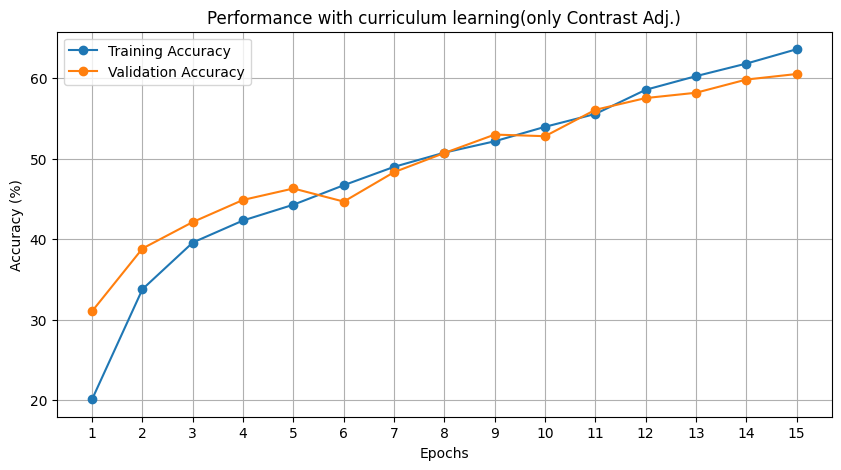

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Performance with curriculum learning(only Contrast Adj.)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(train_accuracies) + 1))
plt.legend()
plt.grid(True)
plt.savefig("only Contrast")
plt.show()

In [18]:
age_groups = [3, 6, 12]
batch_size = 32
train_loaders, val_loaders = [], []

base_train_dataset = CIFAR10(root='./data', train=True, download=True)

for age_months in age_groups:
    print(f"Processing data for age group: {age_months} months")
    
    transform = transforms.Compose([
       
        # Acuity(age_months=age_months),
        # Contrast(age_months=age_months),
         transforms.ToTensor(),
        # transforms.Resize(256)
        
    ])
    
    transformed_dataset = CIFAR10(root='./data', train=True, download=False, transform=transform)
    
    generator = torch.Generator().manual_seed(42)
    train_size = int(0.8 * len(transformed_dataset))
    val_size = len(transformed_dataset) - train_size
    train_data, val_data = random_split(transformed_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

print("Data loaders created for all age groups.")


Files already downloaded and verified
Processing data for age group: 3 months
Processing data for age group: 6 months
Processing data for age group: 12 months
Data loaders created for all age groups.


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

num_epochs = 5
scaler = GradScaler()

best_val_loss = float('inf')

train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for age_group, train_loader in zip(age_groups, train_loaders):
        pbar = tqdm(train_loader, desc=f"Training (Age: {age_group} months)")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'accuracy': 100. * correct / total})
    
    train_loss = running_loss / total
    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for age_group, val_loader in zip(age_groups, val_loaders):
            pbar = tqdm(val_loader, desc=f"Validation (Age: {age_group} months)")
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({'loss': loss.item(), 'accuracy': 100. * correct / total})
    
    val_loss /= total
    val_acc = 100. * correct / total
    val_accuracies.append(val_acc)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
print("Training completed.")
torch.save(model.state_dict(),"noCurriculum.pth")


<ipython-input-19-04fef8e8246c>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # for mixed precision training


Epoch 1/5


Training (Age: 3 months):   0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-19-04fef8e8246c>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
Training (Age: 12 months): 100%|██████████| 1250/1250 [00:07<00:00, 156.52it/s, loss=1.21, accuracy=54.5]


Train Loss: 0.0397, Train Acc: 54.52%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 205.10it/s, loss=1.05, accuracy=61.5]


Validation Loss: 0.0336, Validation Acc: 61.53%
Epoch 2/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 155.14it/s, loss=1.21, accuracy=68.1]


Train Loss: 0.0283, Train Acc: 68.09%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 204.83it/s, loss=0.951, accuracy=64.8]


Validation Loss: 0.0311, Validation Acc: 64.79%
Epoch 3/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:07<00:00, 156.60it/s, loss=0.38, accuracy=73.9]


Train Loss: 0.0232, Train Acc: 73.86%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 210.96it/s, loss=1.06, accuracy=65]


Validation Loss: 0.0322, Validation Acc: 64.99%
Epoch 4/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:08<00:00, 142.92it/s, loss=0.895, accuracy=78.4]


Train Loss: 0.0191, Train Acc: 78.40%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 209.64it/s, loss=0.864, accuracy=66.7]


Validation Loss: 0.0323, Validation Acc: 66.73%
Epoch 5/5


Training (Age: 12 months): 100%|██████████| 1250/1250 [00:07<00:00, 157.44it/s, loss=0.515, accuracy=82.5]


Train Loss: 0.0154, Train Acc: 82.55%


Validation (Age: 12 months): 100%|██████████| 313/313 [00:01<00:00, 209.53it/s, loss=1.03, accuracy=65.8]


Validation Loss: 0.0358, Validation Acc: 65.77%
Training completed.


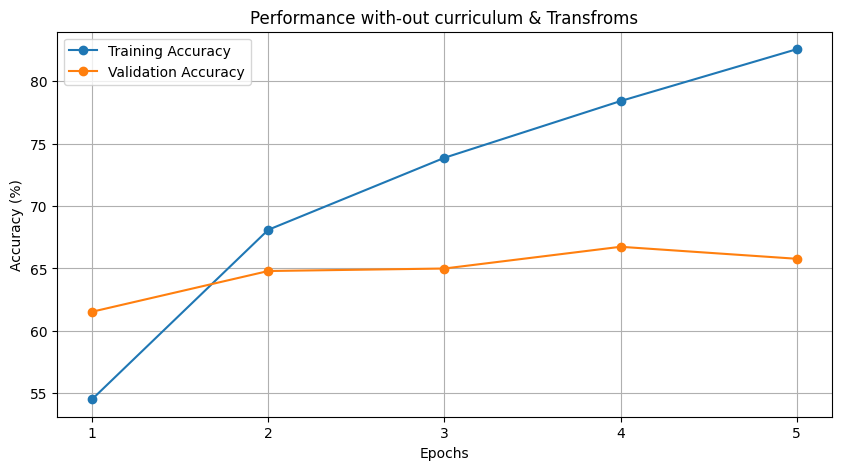

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Performance with-out curriculum & Transfroms')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(train_accuracies) + 1))
plt.legend()
plt.grid(True)
plt.savefig("with-out curriculum")
plt.show()